In [10]:
import cv2
import numpy as np
import os
import time
import joblib
import matplotlib.pyplot as plt


from skimage.feature import hog, local_binary_pattern
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [11]:
DATASET_PATH = "dataset"
MODEL_FILE = "dog_model_hog_lbp.pkl"


IMG_SIZE = (128, 128)
LBP_RADIUS = 1
LBP_POINTS = 8 * LBP_RADIUS


N_SPLITS = 5

In [12]:
def extract_feature(img_bgr):
    img = cv2.resize(img_bgr, IMG_SIZE)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


    hog_feat = hog(
        gray,
        orientations=9,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        block_norm="L2-Hys",
        feature_vector=True
    )

    lbp = local_binary_pattern(gray, LBP_POINTS, LBP_RADIUS, method="uniform")
    lbp_hist, _ = np.histogram(
    lbp.ravel(),
    bins=np.arange(0, LBP_POINTS + 3),
    range=(0, LBP_POINTS + 2)
    )
    lbp_hist = lbp_hist.astype("float")
    lbp_hist /= (lbp_hist.sum() + 1e-6)


    return np.hstack([hog_feat, lbp_hist])

In [13]:
def load_dataset(path):
    X, y = [], []
    print("Loading dataset...")


    for cls in sorted(os.listdir(path)):
        folder = os.path.join(path, cls)
        
        if not os.path.isdir(folder):
            continue


        files = [f for f in os.listdir(folder) if f.lower().endswith((".jpg", ".png", ".jpeg"))]
        print(f" - {cls}: {len(files)} images")


        for f in files:
            img = cv2.imread(os.path.join(folder, f))
            if img is None:
                continue
            
            X.append(extract_feature(img))
            y.append(cls)


    return np.array(X), np.array(y)

In [14]:
def train_and_evaluate(X, y):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)


    skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)


    acc_scores = []
    all_y_true = []
    all_y_pred = []


    for fold, (train_idx, test_idx) in enumerate(skf.split(X_scaled, y)):
        print(f"\nFold {fold+1}/{N_SPLITS}")


        X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]


        clf = SVC(
            kernel="rbf",
            C=10,
            gamma="scale",
            class_weight="balanced",
            probability=False
        )


        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)


        acc = accuracy_score(y_test, y_pred)
        acc_scores.append(acc)
        print(f" Accuracy: {acc:.3f}")


        all_y_true.extend(y_test)
        all_y_pred.extend(y_pred)


    print("\nCross-validation Results")
    print("Mean Accuracy:", np.mean(acc_scores))


    print("\nClassification Report (All folds)")
    print(classification_report(all_y_true, all_y_pred))


    cm = confusion_matrix(all_y_true, all_y_pred)
    return scaler, clf, cm

In [15]:
def train_final_model(X, y):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    clf = SVC(
        kernel="rbf",
        C=10,
        gamma="scale",
        class_weight="balanced",
        probability=False
    )


    clf.fit(X_scaled, y)
    return scaler, clf

In [16]:
def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(6, 5))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)


    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")


    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

In [17]:
def predict_image(image_path, model_data):
    img = cv2.imread(image_path)
    if img is None:
        print("Image not found")
        return

    feat = extract_feature(img).reshape(1, -1)
    feat = model_data['scaler'].transform(feat)

    start = time.time()
    pred = model_data['svm'].predict(feat)[0]
    end = time.time()


    print(f"Prediction: {pred}")
    print(f"Inference time: {(end-start)*1000:.2f} ms")


    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.title(f"Prediction: {pred}")
    plt.axis('off')
    plt.show()

Loading dataset...
 - anjing_kampung: 14 images
 - golden_retriever: 4 images
 - pom: 5 images
 - poodle: 16 images
 - toy_poodle: 8 images
Feature length: 8110

Fold 1/5
 Accuracy: 0.500

Fold 2/5
 Accuracy: 0.700

Fold 3/5
 Accuracy: 0.667

Fold 4/5


c:\Users\Evaldo Raynardi\anaconda3\envs\nlp\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


 Accuracy: 0.667

Fold 5/5
 Accuracy: 0.667

Cross-validation Results
Mean Accuracy: 0.6399999999999999

Classification Report (All folds)
                  precision    recall  f1-score   support

  anjing_kampung       0.90      0.64      0.75        14
golden_retriever       0.00      0.00      0.00         4
             pom       0.00      0.00      0.00         5
          poodle       0.52      0.94      0.67        16
      toy_poodle       0.75      0.75      0.75         8

        accuracy                           0.64        47
       macro avg       0.43      0.47      0.43        47
    weighted avg       0.57      0.64      0.58        47



c:\Users\Evaldo Raynardi\anaconda3\envs\nlp\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Evaldo Raynardi\anaconda3\envs\nlp\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Evaldo Raynardi\anaconda3\envs\nlp\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capital

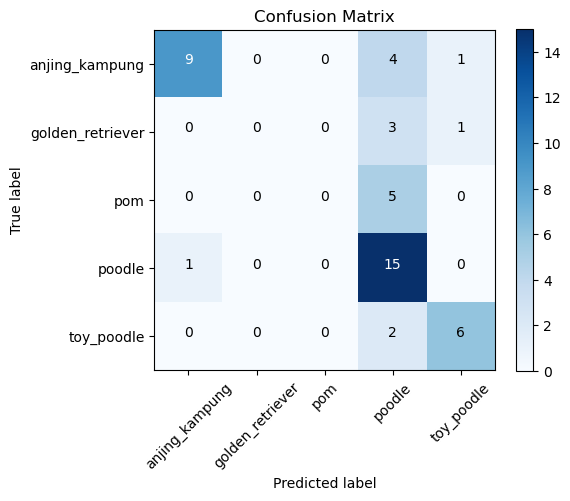


Model saved to dog_model_hog_lbp.pkl
Total time: 3.41s


In [18]:
start = time.time()


X, y = load_dataset(DATASET_PATH)
print("Feature length:", X.shape[1])


scaler_cv, clf_cv, cm = train_and_evaluate(X, y)
plot_confusion_matrix(cm, sorted(set(y)))


scaler, clf = train_final_model(X, y)


joblib.dump({
    "svm": clf,
    "scaler": scaler,
    "classes": sorted(set(y))
}, MODEL_FILE)


print(f"\nModel saved to {MODEL_FILE}")
print(f"Total time: {time.time()-start:.2f}s")